In [1]:
%matplotlib inline
import glob

import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import sklearn.cross_validation as xval
from sklearn.metrics import roc_curve, auc

sns.set(style='whitegrid', font_scale=1.2, rc={'figure.figsize': (10, 8)})

In [2]:
PROTEIN_ALPHABET = 'ACDEFGHIKLMNPQRSTVWY'
PROTEIN_PLACEHOLDER = 'Z'
PROTEIN_LETTERS = PROTEIN_ALPHABET + PROTEIN_PLACEHOLDER

In [3]:
df = pd.read_hdf('../data/combined.h5', 'table')

In [4]:
len(df)

185157

In [20]:
df.head()

,mhc,sequence,meas,p01A,p01C,p01D,p01E,p01F,p01G,p01H,...,fmhc_Patr-B*0901,fmhc_Patr-B*1301,fmhc_Patr-B*1701,fmhc_Patr-B*2401,fmhc_RT1-Bl,fmhc_SLA-1*0401,fmhc_SLA-1*0701,fmhc_SLA-2*0401,fmhc_SLA-3*0401,binds
0,Patr-A*0101,RRDYRRGLZZZ,778.583409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,Patr-A*0101,YHSNVKELZZZ,18806.166640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,Patr-A*0101,AQFSPQYLZZZ,22203.186860,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,Patr-A*0101,GDYKLVEIZZZ,87128.712870,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,Patr-A*0101,RGYVFQGLZZZ,87128.712870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [6]:
meas_threshold = 500

In [7]:
print(df.meas[df.meas < meas_threshold].count())
print(df.meas[df.meas >= meas_threshold].count())

50440
134717


In [8]:
df['binds'] = df.meas.apply(lambda x: x < 500)

In [9]:
train_features = [col for col in df.columns if col[0] == 'f']

In [10]:
X = df[train_features].values
y = df.meas.values

In [12]:
X_train, X_test, y_train, y_test = xval.train_test_split(X, y, test_size=0.2)
dm_train = xgb.DMatrix(X_train, y_train)
dm_test = xgb.DMatrix(X_test, y_test)

In [ ]:
xgb.XGBRegressor(max_depth=100, )

In [17]:
params = {'objective': 'reg:linear', 'max_depth': 100, 'eta': 1, 'gamma': 1, 'lambda': 3}
xgb.cv(params, dm_train, metrics={'rmse'}, nfold=10)
# bst = xgb.train(params, dm_train)

/Users/emil/local/anaconda/lib/python3.5/site-packages/xgboost/training.py:272: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  idset = [randidx[(i * kstep): min(len(randidx), (i + 1) * kstep)] for i in range(nfold)]


,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.850492,0.004032,0.909415,0.001772
1,0.869451,0.004633,0.949543,0.001166
2,0.882717,0.003843,0.966816,0.000671
3,0.889568,0.003572,0.976808,0.000544
4,0.894024,0.002812,0.982933,0.000349
5,0.896461,0.002665,0.987111,0.000339
6,0.898607,0.002067,0.990017,0.000231
7,0.900409,0.002481,0.992122,0.000212
8,0.901954,0.002703,0.993705,0.000156
9,0.902833,0.002830,0.994859,0.000152


In [14]:
pred = bst.predict(dm_test)

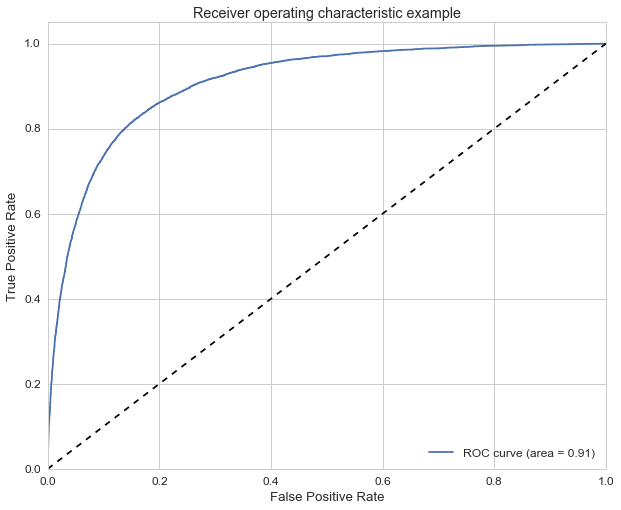

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [18]:
bst.save_model('mhcmodel')